<center>
<h3> Project 3 - Scientific Computing </h3>
<hr>
  
*Letizia D'Achille*
</center>

### Report of numerical results

In [1]:
# Libraries and global variables

import matplotlib.pyplot as plt
import pandas as pd
from time import time
from project3 import *

tol = 1e-8

##### Multigrid in 1d

**Problem:**  

Let $\Omega = (0,1)$.  Given $f\in C^0(\overline\Omega)$ find a $u\in C^2(\overline\Omega)$ such that

\begin{align*}
	−u'' + (2-|x|)u & =  (2x-1)^3 && \quad\text{in } \Omega \\
	u & = 0 && \quad\text{on } \delta \Omega.\\
\end{align*}

**Remark**: We start from an initial guess $\hat u_h^{(0)} = 0$, therefore the residuals at the beginning of the iteration are those reported in the table that follows. We will see how these residuals will decrease using the different methods.

In [2]:
# Residuals computation - 1d

d = {"l" : [], "n" : [], "res" : []}

for l in range(3,15):
	n = 2**l
	h = 1/n
	x = np.linspace(0,1,n+1)
	c = 2 - abs(x)
	uh = np.zeros_like(x)
	fh = (2*x-1)**3

	rh = uh.copy()
	rh[1:n] = fh[1:n] + (uh[0:n-1] + uh[2:n+1] - (2 + c[1:n] * h**2) * uh[1:n]) / h**2
	r = la.norm(rh, np.inf)

	d["l"].append(l)
	d["n"].append(2**l)
	d["res"].append(r)

df = pd.DataFrame(data = d)
emptycol = pd.DataFrame(data = {" " : [' '] * 6})
df_1 = df.iloc[:6:]
df_2 = df.iloc[6::]
df_1.index = [i for i in range(6)]
df_2.index = [i for i in range(6)]
pd.concat([df_1,emptycol,df_2],axis = 1).style \
	.format({'res': "{:.5e}"}) \
	.hide(axis='index')

l,n,res,,l,n,res
3,8,4.21875e-01,,9,512,9.88327e-01
4,16,6.69922e-01,,10,1024,9.94152e-01
5,32,8.23975e-01,,11,2048,9.97073e-01
6,64,9.09149e-01,,12,4096,9.98536e-01
7,128,9.53854e-01,,13,8192,9.99268e-01
8,256,9.76745e-01,,14,16384,9.99634e-01


The following table is related to the weighted Jacobi method.

In [24]:
# Execution of weighted Jacobi method - 1d

d = {"l" : [], "n" : [], "ω" : [], "it" : [], "res" : [], "t" : []}

for l in range(3,10):
	for omega in [1/3, 2/3]:
		n = 2**l
		h = 1/n
		x = np.linspace(0,1,n+1)
		c = 2 - abs(x)
		uh = np.zeros_like(x)
		fh = (2*x-1)**3

		t = time()
		k = 0
		s = 1 + tol
		while s > tol:
			s = jacobi_step_1d(uh, fh, omega)
			k += 1
		t = time() - t

		rh = uh.copy()
		rh[1:n] = fh[1:n] + (uh[0:n-1] + uh[2:n+1] - (2 + c[1:n] * h**2) * uh[1:n]) / h**2
		r = la.norm(rh, np.inf)

		d["l"].append(l)
		d["n"].append(2**l)
		if abs(omega - 1/3) < 0.1: 
			d["ω"].append("1/3") 
		else: 
			d["ω"].append("2/3")
		d["it"].append(k)
		d["res"].append(r)
		d["t"].append(t)

df_j1d = pd.DataFrame(data = d)
emptycol = pd.DataFrame(data = {" " : [' '] * 7})
df_j1d_1 = df_j1d.iloc[::2]
df_j1d_2 = df_j1d.iloc[1::2]
df_j1d_1.index = [i for i in range(7)]
df_j1d_2.index = [i for i in range(7)]
pd.concat([df_j1d_1,emptycol,df_j1d_2],axis = 1).style \
	.set_caption("Weighted Jacobi method - 1d") \
	.format({'res': "{:.5e}"}) \
	.hide(axis='index')

l,n,ω,it,res,t,,l,n,ω,it,res,t
3,8,1/3,200,3.68532e-06,0.008095,,3,8,2/3,111,1.75016e-06,0.003003
4,16,1/3,620,1.52616e-05,0.020452,,4,16,2/3,356,7.58543e-06,0.011815
5,32,1/3,1742,6.13195e-05,0.057096,,5,32,2/3,1057,3.06099e-05,0.034953
6,64,1/3,4665,2.45510e-04,0.152818,,6,64,2/3,2803,1.22618e-04,0.095571
7,128,1/3,13910,9.82660e-04,0.355022,,7,128,2/3,8026,4.90961e-04,0.208308
8,256,1/3,40689,3.93157e-03,1.110255,,8,256,2/3,23970,1.96556e-03,0.660447
9,512,1/3,107303,1.57280e-02,3.128837,,9,512,2/3,67372,7.86367e-03,2.007839


We can immediately observe that all the collected measures grow as $n$ grows. In particular, for a fixed value of $\omega$, we can look at the rate of convergence. Note that:

$$\rho(C_{J_\omega}) = 1 - 2\omega\sin^2\left(h\frac{\pi}{2}\right) = 1 - 2\omega\left(h^2\frac{\pi^2}{4} + O(h^4)\right) = 1 - \frac{\omega}{2}h^2\pi^2 + O(h^4)$$

This estimation does not truly reflects the convergence rate because of the smoothing property of the weighted Jacobi method, but we can still note that the number of iterations are about halved when $\omega$ is doubled. However, we can see that the rate of convergence for both $\omega = \frac{1}{3},\frac{2}{3}$ is about of the order of $h^\frac{3}{2}$, where $h = \frac{1}{n}$. Therefore, the ratio between the number of iterations for $\omega = \frac{1}{3}$ and the one for $\omega = \frac{2}{3}$ tend to diminish as $n$ grows.  
For fixed $n$, the timings are proportional to the number of iterations, therefore we obtain that case $\omega = \frac{2}{3}$ is about twice as fast as case $\omega = \frac{1}{3}$.

Collecting the residuals, we notice that these also grow as $n$ increases. This behavior, which can also be observed in the subsequent tests, can be explained by the fact that a smaller mesh size equals a larger number of points on which we have to approximate the solution. Thus, in general, there is a greater probability that with the same tolerance on the pseudo-residual we will have a solution that struggles to correctly approximate all points at once.  
We can observe that also the residuals are halved when $\omega$ is doubled. In this case the ratio seems to stay the same for all values of $n$. Therefore for $\omega = \frac{2}{3}$ we obtain a more accurate solution in less time than for $\omega = \frac{1}{3}$. We can conclude that over-smoothing is not beneficial to the rate of convergence in the cases under consideration, even if asymptotically the discrepancy could be narrowed and this trend could be reversed.

The following table is related to the two-grid correction scheme.

In [25]:
# Execution of two-grid correction scheme - 1d

d = {"l" : [], "n" : [], "ω" : [], "it" : [], "res" : [], "t" : []}

for l in range(3,10):
	for omega in [1/3, 2/3]:
		n = 2**l
		h = 1/n
		x = np.linspace(0,1,n+1)
		c = 2 - abs(x)
		uh = np.zeros_like(x)
		fh = (2*x-1)**3

		t = time()
		k = 0
		s = 1 + tol
		while s > tol:
			s = two_grid_correction_step_1d(uh, fh, omega)
			k += 1
		t = time() - t

		rh = uh.copy()
		rh[1:n] = fh[1:n] + (uh[0:n-1] + uh[2:n+1] - (2 + c[1:n] * h**2) * uh[1:n]) / h**2
		r = la.norm(rh, np.inf)

		d["l"].append(l)
		d["n"].append(2**l)
		if abs(omega - 1/3) < 0.1: 
			d["ω"].append("1/3") 
		else: 
			d["ω"].append("2/3")
		d["it"].append(k)
		d["res"].append(r)
		d["t"].append(t)

df_t1d = pd.DataFrame(data = d)
emptycol = pd.DataFrame(data = {" " : [' '] * 7})
df_t1d_1 = df_t1d.iloc[::2]
df_t1d_2 = df_t1d.iloc[1::2]
df_t1d_1.index = [i for i in range(7)]
df_t1d_2.index = [i for i in range(7)]
pd.concat([df_t1d_1,emptycol,df_t1d_2],axis = 1).style \
	.set_caption("Two-grid correction scheme - 1d") \
  	.format({'res': "{:.5e}"}) \
	.hide(axis='index')

l,n,ω,it,res,t,,l,n,ω,it,res,t
3,8,1/3,16,4.72159e-07,0.008039,,3,8,2/3,7,7.46975e-08,0.003999
4,16,1/3,28,3.10656e-07,0.012525,,4,16,2/3,16,9.51033e-08,0.007790
5,32,1/3,91,1.35844e-06,0.042101,,5,32,2/3,50,6.79232e-07,0.023038
6,64,1/3,288,5.78767e-06,0.104370,,6,64,2/3,162,2.88145e-06,0.056037
7,128,1/3,864,2.33207e-05,0.296869,,7,128,2/3,504,1.15933e-05,0.177238
8,256,1/3,2328,9.35906e-05,0.854692,,8,256,2/3,1442,4.67025e-05,0.531370
9,512,1/3,6476,3.74456e-04,2.515126,,9,512,2/3,3800,1.87066e-04,1.481666


The considerations made for the weighted Jacobi method still hold for this scheme. Indeed the latter uses the former as building block.  

We now want to compare these two methods. It is clear why iterations decrease, in fact a single iteration of the new scheme includes multiple iterations of the weighted Jacobi method. Moreover we can observe that the ratio between the needed iterations for the base method and those for the new scheme is greater than the number of steps of Jacobi used in the scheme $(12)$. This shows that the reduction to the coarsed grid is much more effective than the simple reiteration of $12$ steps of Jacobi.  
Since the total number of iterations of weighted Jacobi method is indeed reduced, we consequently have that the time required to reach the required tolerance is smaller for the new method. 
Moreover, we can notice that, for fixed $\omega$ and two fixed values of $n$, while the ratio between two values of `it` is the same as before, the ratio between the collected timings is reduced. This happens because we are redirecting the computation of one step of Jacobi on a coarsed grid, that is less expensive on a time basis.

We can notice that for $n$ and $\omega$ fixed, also the residuals associated to the solution obtained at the end of the algorithm are smaller than in the previous case, therefore we can conclude that this scheme is actually improving the previous one in the cases taken into consideration.

The following table is related to the W-cycle method.

In [5]:
# Execution of W-cycle method - 1d

d = {"l" : [], "n" : [], "ω" : [], "α1, α2":[], "it" : [], "res" : [], "t" : []}

for l in range(3,15):
	for alpha1 in [1, 2]:
		for omega in [1/3, 2/3]:
			alpha2 = alpha1
			
			n = 2**l
			h = 1/n
			x = np.linspace(0,1,n+1)
			c = 2 - abs(x)
			uh = np.zeros_like(x)
			fh = (2*x-1)**3

			t = time()
			k = 0
			s = 1 + tol
			while s > tol:
				s = w_cycle_step_1d(uh, fh, omega, alpha1, alpha2)
				k += 1
			t = time() - t
			
			rh = uh.copy()
			rh[1:n] = fh[1:n] + (uh[0:n-1] + uh[2:n+1] - (2 + c[1:n] * h**2) * uh[1:n]) / h**2
			r = la.norm(rh, np.inf)

			d["l"].append(l)
			d["n"].append(2**l)
			if abs(omega - 1/3) < 0.1: 
				d["ω"].append("1/3") 
			else: 
				d["ω"].append("2/3")
			d["α1, α2"].append(alpha1)
			d["it"].append(k)
			d["res"].append(r)
			d["t"].append(t)

df_w1d = pd.DataFrame(data = d)
emptycol = pd.DataFrame(data = {" " : [' '] * 24})
df_w1d_1 = df_w1d.iloc[::2]
df_w1d_2 = df_w1d.iloc[1::2]
df_w1d_1.index = [i for i in range(24)]
df_w1d_2.index = [i for i in range(24)]
pd.concat([df_w1d_1,emptycol,df_w1d_2],axis = 1).style \
	.set_caption("W-cycle - 1d") \
	.format({'res': "{:.5e}"}) \
  	.hide(axis='index')

l,n,ω,"α1, α2",it,res,t,,l,n,ω,"α1, α2",it,res,t
3,8,1/3,1,14,2.44709e-06,0.006310,,3,8,2/3,1,7,1.00471e-07,0.004001
3,8,1/3,2,8,5.26813e-07,0.004354,,3,8,2/3,2,5,1.76419e-07,0.003535
4,16,1/3,1,13,5.33325e-06,0.009368,,4,16,2/3,1,6,2.08932e-06,0.003999
4,16,1/3,2,7,3.67868e-06,0.008578,,4,16,2/3,2,5,2.44260e-07,0.004574
5,32,1/3,1,11,3.36283e-05,0.017315,,5,32,2/3,1,6,3.45227e-06,0.008866
5,32,1/3,2,6,2.20593e-05,0.013641,,5,32,2/3,2,4,6.39343e-06,0.008028
6,64,1/3,1,10,8.59094e-05,0.030948,,6,64,2/3,1,6,4.39671e-06,0.018539
6,64,1/3,2,5,1.26936e-04,0.023212,,6,64,2/3,2,4,6.94824e-06,0.018660
7,128,1/3,1,8,5.24079e-04,0.049819,,7,128,2/3,1,5,4.69334e-05,0.034658
7,128,1/3,2,5,1.28098e-04,0.050893,,7,128,2/3,2,3,1.47894e-04,0.027810


First, let us analyse the pairs of observations for $\omega$ and $n$ fixed. It is clear that when $\alpha_1$ and $\alpha_2$ are greater, the total number of steps required decrease, since a single step includes a greater number of iterations of the base method.  
However, we cannot find any general rule about whether is better to increase $\alpha_1$ and $\alpha_2$ or not, since both the timings and the residuals have no fixed order relation. Indeed, there are cases when we can reach the tolerance with fewer steps when $\alpha_1=\alpha_2=2$, then the timings result better. However, when we reach the tolerance with the same number of steps for both the possible values, then the case with $\alpha_1=\alpha_2=1$ has an advantage since it executes a fewer number of operations. For example, we see this trend when $n$ becomes high, and the tolerance is always reached with one single step.  

On the other hand, if we fix $\alpha_1$, $\alpha_2$ and $n$, one can observe that if the tolerance is reached with the same number of iterations for the two values of $\omega$, we can see the timings are the same. This is quite obvious since one step of the W-cycle method takes the same amount of time for both values of $\omega$. This becomes relevant for higher values of $n$ where the tolerance is reached with $1/2$ iterations in both cases. In those cases we can look at the residuals and observe that we obtain smaller values for $\omega = \frac{2}{3}$, which is then again the best choice.  
Even when we do not have a match between the number of iterations, we can observe that $\omega = \frac{2}{3}$ is better since it always requires a smaller number of steps. Also the residuals mantain the same order relation.  

We immediately observe that, unlike the previous methods, the number of iterations does not increase (indeed, it decreases), which means they do not depend on $n$ as expected from the theory.  
Also the timings have a different behaviour with respect to the previous tables: again they adhere to theory, as the complexity appears to be $O(n)$.


The following table is related to the full multigrid method.

In [6]:
# Execution of full multigrid method - 1d

d = {"l" : [], "n" : [], "α1, α2":[], "ν": [], "p-res" : [], "res" : [], "t" : []}

for l in range(3,15):
	for alpha1, nu in [(1,1),(1,2),(2,1),(2,2)]:
		omega = 2/3
		alpha2 = alpha1
		
		n = 2**l
		h = 1/n
		x = np.linspace(0,1,n+1)
		c = 2 - abs(x)
		uh = np.zeros_like(x)
		fh = (2*x-1)**3

		t = time()
		s = full_mg_1d(uh, fh, omega, alpha1, alpha2, nu)
		t = time() - t

		rh = uh.copy()
		rh[1:n] = fh[1:n] + (uh[0:n-1] + uh[2:n+1] - (2 + c[1:n] * h**2) * uh[1:n]) / h**2
		r = la.norm(rh, np.inf)

		d["l"].append(l)
		d["n"].append(2**l)
		d["α1, α2"].append(alpha1)
		d["ν"].append(nu)
		d["p-res"].append(s)
		d["res"].append(r)
		d["t"].append(t)

df_f1d = pd.DataFrame(data = d)
emptycol = pd.DataFrame(data = {" " : [' '] * 24})
df_f1d_1 = df_f1d.iloc[::2]
df_f1d_2 = df_f1d.iloc[1::2]
df_f1d_1.index = [i for i in range(24)]
df_f1d_2.index = [i for i in range(24)]
pd.concat([df_f1d_1,emptycol,df_f1d_2],axis = 1).style \
	.set_caption("Full multigrid - 1d (ω = 2/3)") \
	.format({'res': "{:.5e}", 'p-res': "{:.5e}"}) \
	.hide(axis='index')

l,n,"α1, α2",ν,p-res,res,t,,l,n,"α1, α2",ν,p-res,res,t
3,8,1,1,4.19419e-04,2.34099e-02,0.002016,,3,8,1,2,4.22052e-05,2.52555e-03,0.004202
3,8,2,1,4.26623e-05,5.32322e-03,0.001007,,3,8,2,2,2.54176e-06,1.99729e-04,0.002020
4,16,1,1,1.28228e-04,3.16707e-02,0.002007,,4,16,1,2,1.62135e-05,3.50251e-03,0.003511
4,16,2,1,2.30877e-05,8.53432e-03,0.003239,,4,16,2,2,1.06808e-06,3.37682e-04,0.005995
5,32,1,1,5.50387e-05,4.80570e-02,0.005016,,5,32,1,2,6.62361e-06,5.61246e-03,0.008645
5,32,2,1,8.66467e-06,1.05980e-02,0.006795,,5,32,2,2,3.70302e-07,4.13164e-04,0.011513
6,64,1,1,1.90449e-05,7.30384e-02,0.008514,,6,64,1,2,2.21215e-06,8.34594e-03,0.012857
6,64,2,1,2.63466e-06,1.17645e-02,0.008267,,6,64,2,2,1.04205e-07,4.42979e-04,0.019375
7,128,1,1,5.61247e-06,9.03381e-02,0.012536,,7,128,1,2,6.41278e-07,1.01688e-02,0.024567
7,128,2,1,7.24012e-07,1.23825e-02,0.018681,,7,128,2,2,2.72738e-08,4.54534e-04,0.037236


Let us analyse the observations with respect to the value of $\nu$. We know that changing the value of $\nu$ only modifies the number of steps of the W-cycle method at the end of the execution of the method. Then it becomes clear why the timings for $\nu = 2$ are twice as high as those for $\nu = 1$.  
For the same reason both the residuals and pseudo-residuals decrease for an higher $\nu$. In particular, the pseudo-residuals decrease by one order of magnitude, while the residuals, especially for the higher values of $l$, are squared. This a great advantage, since the we gain a quadratic reduction on residuals while we have a linear increase on timings. This happens because we are spending more time on the coarser grids, and for high $l$ this becomes convenient.  
Moreover, the considerations about the different values of $\alpha_1$ and $\alpha_2$ made for the W-cycle method can be repeated in a similar manner. Since we are executing a single step, we will clearly have worst timings for $\alpha_1=\alpha_2=2$, but in this case we reach better residuals.

As $n$ grows, we can notice that pseudo-residuals decrease. This can be explained looking at how one step of the W-cycle method works. Indeed, this executes a great number of iterations of Jacobi on different grids in order to reach the coarser one. In particular, it executes an high number of corrections, one for every grid it goes through (this number corresponds to $l$). Hence at the end, even if it is more expensive in terms of time, we reach a smaller pseudo-residual. Here is also why, in the table related to W-cycle method, we observe a reduction of the number of iterations as $n$ grows. In this table we can indeed see that, for the higher values of $l$, the tolerance required in the previous cases is easily reached by a single step of the W-cycle. Additionally, we can note that we have a few more cases that immediately reach the required tolerance in one step than in a straightforward implementation of the W-cycle. This is due to the first phase of the full multigrid method, in which we obtain an approximation from which we can start the execution of the W-cycle.  

On the other hand, as $n$ grows, the residuals slightly increase. As we already remarked, this is an expectable behaviour since we work on increasingly fine grids. 

##### Approximation to the solution - 1d

--------------------------------------------------
min = -0.00640896391678448
max = 0.006541919793724749
--------------------------------------------------


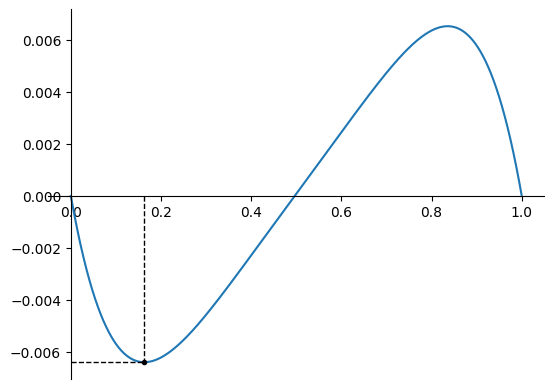

In [7]:
# Computation of an approximation to the solution of 1d problem and its minimum (and maximum), and plot

l = 14; omega = 2/3;  alpha2 = alpha1 = 2; nu = 2

n = 2**l
h = 1/n
x = np.linspace(0,1,n+1)
uh = np.zeros_like(x)
fh = fh = (2*x-1)**3

_ = full_mg_1d(uh, fh, omega, alpha1, alpha2, nu)

argmin = np.argmin(uh)
argmax = np.argmax(uh)
print("-"*50)
print(f"min = {uh[argmin]}")
print(f"max = {uh[argmax]}")
print("-"*50)

fig, ax = plt.subplots(1)
ax.plot(x, uh)
ax.plot(x[argmin], uh[argmin], c='k', marker='.')
ax.plot([x[argmin],x[argmin]], [0,uh[argmin]], c='k', ls = '--', lw = '1')
ax.plot([0,x[argmin]], [uh[argmin],uh[argmin]], c='k', ls = '--', lw = '1')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
plt.show()

In order to approximate the solution, we first chose $l = 14$ to obtain a figure as homogeneous as possible. Among the two methods for which we computed the solution for this value of $l$, and among the various parameters, we then chose the ones for which we obtained the smaller residual. Hence, we chose full-multigrid method with parameters $\alpha1 = \alpha2 = 2$, $\nu = 2$. The minimum was computed using the final solution, and it was plotted together with the approximation.

##### Multigrid in 2d

**Problem:**  

Let $\Omega = (0,1)^2$.  Given $f\in C^0(\overline\Omega)$ find a $u\in C^2(\overline\Omega)$ such that

\begin{align*}
	−\Delta u + \left(2-\sqrt{x_1^2 + x_2^2}\ \right)u & =  3 x_1^4 - x_2^2 && \quad\text{in } \Omega \\
	u & = 0 && \quad\text{on } \delta \Omega.\\
\end{align*}

**Remark**: Again we start from an initial guess $\hat u_h^{(0)} = 0$, therefore the residuals at the beginning of the iteration are those reported in the table that follows. 

In [37]:
# Residuals computation - 2d

d = {"l" : [], "n" : [], "res" : []}

for l in range(2,12):
	n = 2**l
	h = 1/n
	x = np.linspace(0, 1, n+1)
	y = np.linspace(0, 1, n+1)
	x, y = np.meshgrid(x, y)
	c = 2 - np.sqrt(x**2 + y**2)
	uh = np.zeros_like(x)
	fh = 3*x**4 - y**2

	rh = uh.copy()
	rh[1:n,1:n] = fh[1:n,1:n] + (uh[0:n-1,1:n] + uh[2:n+1,1:n] + uh[1:n,0:n-1] + uh[1:n,2:n+1] - (4 + c[1:n,1:n] * h**2) * uh[1:n,1:n]) / h**2
	r = la.norm(rh.flat, np.inf)

	d["l"].append(l)
	d["n"].append(2**l)
	d["res"].append(r)

df = pd.DataFrame(data = d)
emptycol = pd.DataFrame(data = {" " : [' '] * 5})
df_1 = df.iloc[:5:]
df_2 = df.iloc[5::]
df_1.index = [i for i in range(5)]
df_2.index = [i for i in range(5)]
pd.concat([df_1,emptycol,df_2],axis = 1).style \
	.format({'res': "{:.5e}"}) \
	.hide(axis='index')

l,n,res,,l,n,res
2,4,8.86719e-01,,7,128,2.90728e+00
3,8,1.74292e+00,,8,256,2.95338e+00
4,16,2.31352e+00,,9,512,2.97663e+00
5,32,2.64124e+00,,10,1024,2.98830e+00
6,64,2.81660e+00,,11,2048,2.99414e+00


The following table is related to the weighted Jacobi method.

In [27]:
# Execution of weighted Jacobi method - 2d

d = {"l" : [], "n" : [], "ω" : [], "it" : [], "res" : [], "t" : []}

for l in range(2,8):
	for omega in [1/3, 2/3]:
		n = 2**l
		h = 1/n
		x = np.linspace(0, 1, n+1)
		y = np.linspace(0, 1, n+1)
		x, y = np.meshgrid(x, y)
		c = 2 - np.sqrt(x**2 + y**2)
		uh = np.zeros_like(x)
		fh = 3*x**4 - y**2

		t = time()
		k = 0
		s = 1 + tol
		while s > tol:
			s = jacobi_step_2d(uh, fh, omega)
			k += 1
		t = time() - t

		rh = uh.copy()
		rh[1:n,1:n] = fh[1:n,1:n] + (uh[0:n-1,1:n] + uh[2:n+1,1:n] + uh[1:n,0:n-1] + uh[1:n,2:n+1] - (4 + c[1:n,1:n] * h**2) * uh[1:n,1:n]) / h**2
		r = la.norm(rh.flat, np.inf)
		
		d["l"].append(l)
		d["n"].append(2**l)
		if abs(omega - 1/3) < 0.1: 
			d["ω"].append("1/3") 
		else: 
			d["ω"].append("2/3")
		d["it"].append(k)
		d["res"].append(r)
		d["t"].append(t)

df_j2d = pd.DataFrame(data = d)
emptycol = pd.DataFrame(data = {" " : [' '] * 6})
df_j2d_1 = df_j2d.iloc[::2]
df_j2d_2 = df_j2d.iloc[1::2]
df_j2d_1.index = [i for i in range(6)]
df_j2d_2.index = [i for i in range(6)]
pd.concat([df_j2d_1,emptycol,df_j2d_2],axis = 1).style \
	.set_caption("Weighted Jacobi method - 2d") \
	.format({'res': "{:.5e}"}) \
	.hide(axis='index')

l,n,ω,it,res,t,,l,n,ω,it,res,t
2,4,1/3,103,1.60218e-06,0.010767,,2,4,2/3,52,7.29828e-07,0.004999
3,8,1/3,368,7.48354e-06,0.032726,,3,8,2/3,195,3.53954e-06,0.017311
4,16,1/3,1277,3.04295e-05,0.109964,,4,16,2/3,688,1.49787e-05,0.052174
5,32,1/3,4303,1.22604e-04,0.371403,,5,32,2/3,2353,6.11444e-05,0.203697
6,64,1/3,13975,4.91252e-04,1.672747,,6,64,2/3,7798,2.45365e-04,0.918512
7,128,1/3,42935,1.96584e-03,9.555902,,7,128,2/3,24710,9.82673e-04,5.552430


All the remarks made for 1d case can be brought to this case. Indeed,

$$C_{J_\omega}^{2d} = I - \left(\frac{1}{\omega}D\right)^{-1}A_h = I - \frac{\omega}{4}h^2A_h$$

$$\rho(C_{J_\omega}^{2d}) = 1 - 2\omega\sin^2\left(h\frac{\pi}{2}\right) = \rho(C_{J_\omega})$$

We can notice that in this case the timings grow faster than in 1d with respect to the iterations. Indeed the number of operation per step is squared than in the previous case as the number of points on which we are approximating the solution is squared, therefore we could expect this behaviour. 
The values for the number of iterations themselves are higher than in 1d, but this mainly depends on the different types of problem we are taking into consideration.

The following table is related to the two-grid correction scheme.

In [28]:
# Execution of two-grid correction scheme - 2d

d = {"l" : [], "n" : [], "ω" : [], "it" : [], "res" : [], "t" : []}

for l in range(2,8):
	for omega in [1/3, 2/3]:
		n = 2**l
		h = 1/n
		x = np.linspace(0, 1, n+1)
		y = np.linspace(0, 1, n+1)
		x, y = np.meshgrid(x, y)
		c = 2 - np.sqrt(x**2 + y**2)
		uh = np.zeros_like(x)
		fh = 3*x**4 - y**2

		t = time()
		k = 0
		s = 1 + tol
		while s > tol:
			s = two_grid_correction_step_2d(uh, fh, omega)
			k += 1
		t = time() - t

		rh = uh.copy()
		rh[1:n,1:n] = fh[1:n,1:n] + (uh[0:n-1,1:n] + uh[2:n+1,1:n] + uh[1:n,0:n-1] + uh[1:n,2:n+1] - (4 + c[1:n,1:n] * h**2) * uh[1:n,1:n]) / h**2
		r = la.norm(rh.flat, np.inf)

		d["l"].append(l)
		d["n"].append(2**l)
		if abs(omega - 1/3) < 0.1: 
			d["ω"].append("1/3") 
		else: 
			d["ω"].append("2/3")
		d["it"].append(k)
		d["res"].append(r)
		d["t"].append(t)

df_t2d = pd.DataFrame(data = d)
emptycol = pd.DataFrame(data = {" " : [' '] * 6})
df_t2d_1 = df_t2d.iloc[::2]
df_t2d_2 = df_t2d.iloc[1::2]
df_t2d_1.index = [i for i in range(6)]
df_t2d_2.index = [i for i in range(6)]
pd.concat([df_t2d_1,emptycol,df_t2d_2],axis = 1).style \
	.set_caption("Two-grid correction scheme - 2d") \
  	.format({'res': "{:.5e}"}) \
	.hide(axis='index')

l,n,ω,it,res,t,,l,n,ω,it,res,t
2,4,1/3,28,6.58007e-07,0.029043,,2,4,2/3,14,7.04928e-08,0.011515
3,8,1/3,31,2.63811e-06,0.030591,,3,8,2/3,16,3.68569e-07,0.015939
4,16,1/3,46,8.02714e-07,0.046018,,4,16,2/3,25,2.00572e-07,0.024977
5,32,1/3,157,2.87447e-06,0.168913,,5,32,2/3,83,1.41642e-06,0.089100
6,64,1/3,543,1.16979e-05,0.712150,,6,64,2/3,291,5.72557e-06,0.375596
7,128,1/3,1857,4.68064e-05,3.640157,,7,128,2/3,1006,2.32684e-05,1.954349


Again, the considerations remain unchanged. Note that in 2d we are starting from a smaller $n$, and for the smallest values of this parameter behaviour seems dissimilar. However, even if we have few observations, we can see that when $n$ becomes big the method performs in the same way.  
The improvement in timings are now much more convenient than in 1d, since these tend to grow very quickly.

The following table is related to the W-cycle method.

In [29]:
# Execution of W-cycle method - 2d

d = {"l" : [], "n" : [], "ω" : [], "α1, α2":[], "it" : [], "res" : [], "t" : []}

for l in range(2,11):
	for alpha1 in [1, 2]:
		for omega in [1/3, 2/3]:
			alpha2 = alpha1
			
			n = 2**l
			h = 1/n
			x = np.linspace(0, 1, n+1)
			y = np.linspace(0, 1, n+1)
			x, y = np.meshgrid(x, y)
			c = 2 - np.sqrt(x**2 + y**2)
			uh = np.zeros_like(x)
			fh = 3*x**4 - y**2

			t = time()
			k = 0
			s = 1 + tol
			while s > tol:
				s = w_cycle_step_2d(uh, fh, omega, alpha1, alpha2)
				k += 1
			t = time() - t

			rh = uh.copy()
			rh[1:n,1:n] = fh[1:n,1:n] + (uh[0:n-1,1:n] + uh[2:n+1,1:n] + uh[1:n,0:n-1] + uh[1:n,2:n+1] - (4 + c[1:n,1:n] * h**2) * uh[1:n,1:n]) / h**2
			r = la.norm(rh.flat, np.inf)

			d["l"].append(l)
			d["n"].append(2**l)
			if abs(omega - 1/3) < 0.1: 
				d["ω"].append("1/3") 
			else: 
				d["ω"].append("2/3")
			d["α1, α2"].append(alpha1)
			d["it"].append(k)
			d["res"].append(r)
			d["t"].append(t)

df_w2d = pd.DataFrame(data = d)
emptycol = pd.DataFrame(data = {" " : [' '] * 18})
df_w2d_1 = df_w2d.iloc[::2]
df_w2d_2 = df_w2d.iloc[1::2]
df_w2d_1.index = [i for i in range(18)]
df_w2d_2.index = [i for i in range(18)]
pd.concat([df_w2d_1,emptycol,df_w2d_2],axis = 1).style \
	.set_caption("W-cycle - 2d") \
	.format({'res': "{:.5e}"}) \
  	.hide(axis='index')

l,n,ω,"α1, α2",it,res,t,,l,n,ω,"α1, α2",it,res,t
2,4,1/3,1,27,1.07551e-06,0.010314,,2,4,2/3,1,13,2.21969e-07,0.006286
2,4,1/3,2,14,6.72291e-07,0.009040,,2,4,2/3,2,7,2.63420e-07,0.003999
3,8,1/3,1,30,4.16436e-06,0.034501,,3,8,2/3,1,14,2.34798e-06,0.016022
3,8,1/3,2,15,4.65160e-06,0.019527,,3,8,2/3,2,8,9.23030e-07,0.012381
4,16,1/3,1,28,2.11860e-05,0.058701,,4,16,2/3,1,14,5.73735e-06,0.029655
4,16,1/3,2,14,2.33876e-05,0.044314,,4,16,2/3,2,8,1.79674e-06,0.025102
5,32,1/3,1,25,8.91671e-05,0.114300,,5,32,2/3,1,13,1.70887e-05,0.059698
5,32,1/3,2,13,6.38671e-05,0.087910,,5,32,2/3,2,7,1.16786e-05,0.046521
6,64,1/3,1,22,3.26575e-04,0.209508,,6,64,2/3,1,11,1.05444e-04,0.105098
6,64,1/3,2,11,3.36439e-04,0.161881,,6,64,2/3,2,6,6.76926e-05,0.086058


In this case, since we do not reach a case in which for different values of $\alpha_1$, $\alpha_2$ we have the same number of iterations, we can state that the case $\alpha_1 = \alpha_2 = 2$ appears to be better than the other. Indeed, both the timings and the residuals seem to experience a non-negligible improvement. 
We only have a couple of counterexamples for $l=7,8$ and $\omega = \frac{2}{3}$.

We can still have the same remarks as in the case 1d, but in this case the number of unknowns is squared, therefore the timings should follow the theoretical complexity $O(n^2)$. In practice, we still have a linear growth, at least for the values considered for $n$. This probably is caused by the efficient implementation of operations among numpy arrays, that do not make the computation explode for $n$ this small. We begin to see the quadratic behavious in the step from $l=9$ to $l=10$.

The following table is related to the full multigrid method.

In [35]:
# Execution of full multigrid method - 2d

d = {"l" : [], "n" : [], "α1, α2":[], "ν": [], "p-res" : [], "res" : [], "t" : []}

for l in range(2,11):
	for alpha1, nu in [(1,1),(1,2),(2,1),(2,2)]:
		omega = 2/3
		alpha2 = alpha1

		n = 2**l
		h = 1/n
		x = np.linspace(0, 1, n+1)
		y = np.linspace(0, 1, n+1)
		x, y = np.meshgrid(x, y)
		c = 2 - np.sqrt(x**2 + y**2)
		uh = np.zeros_like(x)
		fh = 3*x**4 - y**2

		t = time()
		s = full_mg_2d(uh, fh, omega, alpha1, alpha2, nu)
		t = time() - t

		rh = uh.copy()
		rh[1:n,1:n] = fh[1:n,1:n] + (uh[0:n-1,1:n] + uh[2:n+1,1:n] + uh[1:n,0:n-1] + uh[1:n,2:n+1] - (4 + c[1:n,1:n] * h**2) * uh[1:n,1:n]) / h**2
		r = la.norm(rh.flat, np.inf)

		d["l"].append(l)
		d["n"].append(2**l)
		d["α1, α2"].append(alpha1)
		d["ν"].append(nu)
		d["p-res"].append(s)
		d["res"].append(r)
		d["t"].append(t)

df_f2d = pd.DataFrame(data = d)
emptycol = pd.DataFrame(data = {" " : [' '] * 18})
df_f2d_1 = df_f2d.iloc[::2]
df_f2d_2 = df_f2d.iloc[1::2]
df_f2d_1.index = [i for i in range(18)]
df_f2d_2.index = [i for i in range(18)]
pd.concat([df_f2d_1,emptycol,df_f2d_2],axis = 1).style \
	.set_caption("Full multigrid - 2d (ω = 2/3)") \
	.format({'res': "{:.5e}", 'p-res': "{:.5e}"}) \
	.hide(axis='index')

l,n,"α1, α2",ν,p-res,res,t,,l,n,"α1, α2",ν,p-res,res,t
2,4,1,1,4.30575e-03,2.26000e-01,0.000631,,2,4,1,2,1.27866e-03,6.94729e-02,0.001005
2,4,2,1,1.29299e-03,7.09180e-02,0.001017,,2,4,2,2,1.36426e-04,7.55402e-03,0.001016
3,8,1,1,2.57091e-03,5.62858e-01,0.001262,,3,8,1,2,8.28356e-04,1.86071e-01,0.004543
3,8,2,1,8.71046e-04,2.02816e-01,0.002383,,3,8,2,2,1.32385e-04,3.14976e-02,0.005401
4,16,1,1,8.99462e-04,7.73811e-01,0.003565,,4,16,1,2,2.77889e-04,2.52592e-01,0.009071
4,16,2,1,2.88549e-04,2.69183e-01,0.005236,,4,16,2,2,4.29197e-05,4.14054e-02,0.010725
5,32,1,1,2.59545e-04,8.94022e-01,0.008229,,5,32,1,2,7.74156e-05,2.78613e-01,0.015737
5,32,2,1,8.03878e-05,2.97644e-01,0.012353,,5,32,2,2,1.15884e-05,4.47541e-02,0.025118
6,64,1,1,6.95980e-05,9.52338e-01,0.016905,,6,64,1,2,2.02136e-05,2.89596e-01,0.035285
6,64,2,1,2.09931e-05,3.09518e-01,0.026832,,6,64,2,2,2.96939e-06,4.58251e-02,0.052269


The remarks made in the previous sections can be analogously repeated here. In 2d the residuals are not squared when doubling $\nu$, but there is still a great improvement with respect to the modifications in timings.  
Note that the residuals are always high with respect to those obtained in 1d case, but we have to consider that the starting error was high as well. We still have the good property of slow growth of residuals.

##### Approximation to the solution - 2d

--------------------------------------------------
min = -0.011749138344498877
max = 0.027104570049559965
--------------------------------------------------


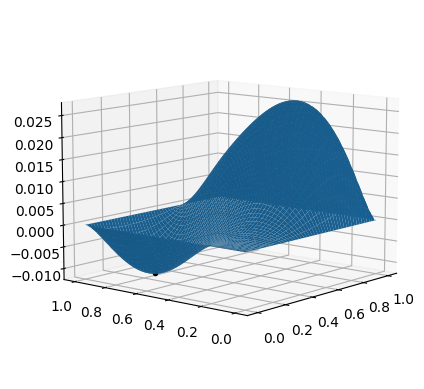

In [36]:
# Computation of an approximation to the solution of 2d problem and its minimum (and maximum), and plot

l = 10; omega = 2/3; alpha2 = alpha1 = 2

n = 2**l
h = 1/n
x = np.linspace(0, 1, n+1)
y = np.linspace(0, 1, n+1)
x, y = np.meshgrid(x, y)
uh = np.zeros_like(x)
fh = 3*x**4 - y**2

s = 1 + tol
while  s > tol:
	s = w_cycle_step_2d(uh, fh, omega, alpha1, alpha2)

argmin = np.unravel_index(np.argmin(uh), uh.shape)
argmax = np.unravel_index(np.argmax(uh), uh.shape)
print("-"*50)
print(f"min = {uh[argmin]}")
print(f"max = {uh[argmax]}")
print("-"*50)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x, y, uh)
plt.plot(x[argmin], y[argmin], uh[argmin], c='k', marker='.')
ax.view_init(10, -140)
plt.show()

In order to approximate the solution, we first chose $l = 10$ to obtain a figure as homogeneous as possible. Among the two methods for which we computed the solution for this value of $l$, and among the various parameters, we then chose the ones for which we obtained the smaller residual, as we did for 1d. In this case, we chose W-cycle method with parameters $\omega = \frac{2}{3}$ and $\alpha1 = \alpha2 = 2$. The minimum was computed using the final solution, and it was plotted together with the approximation.  
Looking at the plot also becomes clear how this problem is not comparable to the one in 1d, indeed the solution is further from the initial approximation than the one in 1d, and behaves quite differently. In particular, this also clearly confirms the calculation of initial residuals.